In [1]:
import pandas as pd
import numpy as np
import re
import os
import sys
import nltk
from nltk.corpus import stopwords
from numpy import array
from numpy import asarray
from numpy import zeros
import matplotlib.pyplot as plt
from numpy import array

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers import Conv1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM


Using TensorFlow backend.
/Users/anirudhmuthukumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/anirudhmuthukumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/anirudhmuthukumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/anirudhmuthuk

In [59]:
dataset_path = sys.path[0] + '/dataset/'
model_path  = sys.path[0] + '/models/'

### Loading the Twitter dataset

In [60]:
tweets_dataset = pd.read_csv(dataset_path + 'twitter_sentiments.csv')

In [61]:
print(tweets_dataset.shape)
print(tweets_dataset.head(10))

(31962, 3)
   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation
5   6      0  [2/2] huge fan fare and big talking before the...
6   7      0   @user camping tomorrow @user @user @user @use...
7   8      0  the next school year is the year for exams.ð...
8   9      0  we won!!! love the land!!! #allin #cavs #champ...
9  10      0   @user @user welcome here !  i'm   it's so #gr...


In [62]:
print(tweets_dataset['tweet'][5])

[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo  


### Preprocessing of tweets

In [63]:
def remove_tags(text):
    TAG_RE = re.compile(r'<[^>]+>')
    return TAG_RE.sub('', text)

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [64]:
X = []
sentences = list(tweets_dataset['tweet'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [65]:
print(X[5])

 huge fan fare and big talking before they leave chaos and pay disputes when they get there allshowandnogo 


In [75]:
y = tweets_dataset['label']
y = np.array(y)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=682)

In [77]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [78]:
find_len = lambda x: len(x)
longest_sentence_len = max(find_len(sent) for sent in X_train)
print(longest_sentence_len)

39


In [79]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 35

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [80]:
embeddings_dictionary = dict()
glove_file = open(dataset_path + 'glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [81]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## RNN (LSTM)

In [83]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 35, 100)           3282500   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 3,399,877
Trainable params: 117,377
Non-trainable params: 3,282,500
_________________________________________________________________
None


In [84]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Train on 20455 samples, validate on 5114 samples
Epoch 1/6
20455/20455 [==============================] - 40s 2ms/step - loss: 0.2730 - acc: 0.9279 - val_loss: 0.2366 - val_acc: 0.9314
Epoch 2/6
20455/20455 [==============================] - 37s 2ms/step - loss: 0.2073 - acc: 0.9305 - val_loss: 0.1713 - val_acc: 0.9314
Epoch 3/6
20455/20455 [==============================] - 44s 2ms/step - loss: 0.1686 - acc: 0.9362 - val_loss: 0.1587 - val_acc: 0.9456
Epoch 4/6
20455/20455 [==============================] - 44s 2ms/step - loss: 0.1551 - acc: 0.9439 - val_loss: 0.1540 - val_acc: 0.9447
Epoch 5/6
20455/20455 [==============================] - 41s 2ms/step - loss: 0.1427 - acc: 0.9472 - val_loss: 0.1493 - val_acc: 0.9484
Epoch 6/6
20455/20455 [==============================] - 39s 2ms/step - loss: 0.1375 - acc: 0.9507 - val_loss: 0.1462 - val_acc: 0.9496


In [85]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Accuracy:", score[1])

6393/6393 [==============================] - 6s 907us/step
Test Accuracy: 0.9482246041297913


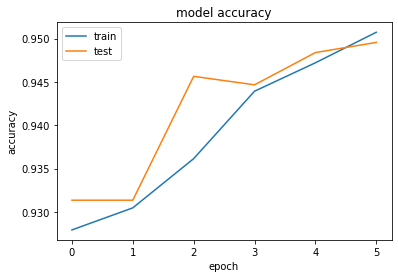

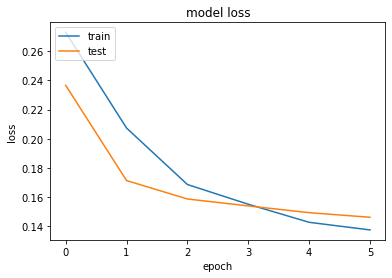

In [86]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [87]:
model.save(model_path + 'rnn_lstm_twitter.h5')